In [32]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
import tqdm

# for data preprocessing and error analysis
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error 

# GPytorch
import gpytorch
import torch

# Syntatic data

In [33]:
# Import the sklearn datasets
import sklearn.datasets as sdt

# Create a non-linear distribution using the Friedman #1 function
n_samples = 1000
n_feats = 6
n_info = 3
x, y = sdt.make_regression(
        n_samples=n_samples,
        n_features=n_feats,
        n_informative=n_info,
        noise=1.0,
        random_state=42,
)

print(x.shape, y.shape)

(1000, 6) (1000,)


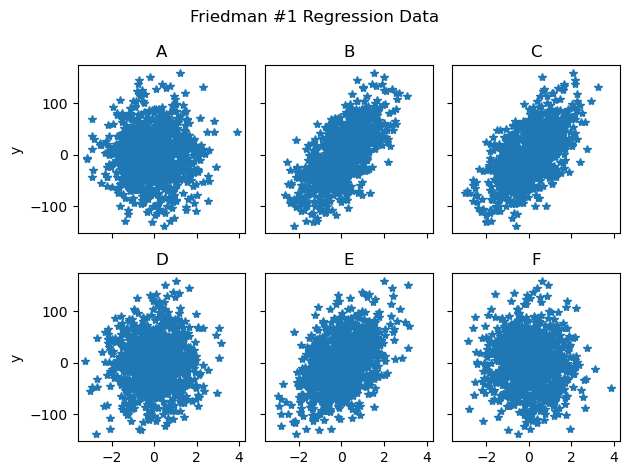

In [34]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Friedman #1 Regression Data')
fig.tight_layout()
plt.show()

In [35]:
scaler = preprocessing.StandardScaler().fit(x)
x_norm = scaler.transform(x)

scaler_y = preprocessing.StandardScaler().fit(y.reshape(-1, 1))
y_norm = scaler_y.transform(y.reshape(-1, 1))

print(f"x_norm.shape:{x_norm.shape}")
print(f"y_norm.shape:{y_norm.shape}")

x_norm.shape:(1000, 6)
y_norm.shape:(1000, 1)


In [36]:
# Set aside 15% of the data for future testing
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.15, shuffle=True, random_state=42)
print(f"test data: {x_test.shape}, {y_test.shape}")
print(f"train data: {x_train.shape}, {y_train.shape}")

x_train_torch = torch.from_numpy(x_train)
y_train_torch = torch.from_numpy(y_train.flatten())

x_train_real = scaler_y.inverse_transform(x_train)
x_test_real = scaler_y.inverse_transform(x_test)
y_train_real = scaler_y.inverse_transform(y_train)
y_test_real = scaler_y.inverse_transform(y_test)

test data: (150, 6), (150, 1)
train data: (850, 6), (850, 1)


## GP using GPytorch

In [37]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train_torch, y_train_torch, likelihood)

100%|██████████| 300/300 [00:13<00:00, 21.82it/s, loss=-2.07, noise=0.000395, lengthscale=7.8] 

CPU times: user 1min 35s, sys: 5.21 s, total: 1min 40s
Wall time: 13.8 s


[Text(0.5, 1.0, 'Loss'),
 Text(0.5, 0, 'Iterations'),
 Text(0, 0.5, 'Negative Log-Likelihood')]

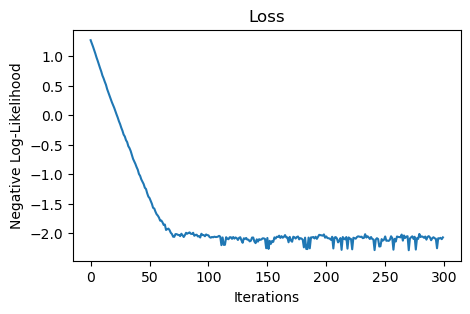

In [38]:
%%time
model.train()
likelihood.train()

training_iter = 300
learning_rate = 0.1

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)       # "Loss" for GPs - the marginal log likelihood

losses =  []
with tqdm.trange(training_iter) as pbar:
    for i in pbar:
        optimizer.zero_grad()                                   # Zero gradients from previous iteration
        output = model(x_train_torch)                 # Output from model
        loss = -mll(output, y_train_torch)  # Calc loss, the marginal log likelihood
        
        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item(),'noise': model.likelihood.noise.item(), 'lengthscale':model.covar_module.base_kernel.lengthscale.item()})

        model.train()
        likelihood.train()
        
        loss.backward()  # backprop gradients
        optimizer.step()

g, ax = plt.subplots(figsize=(5, 3))
ax.plot(losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")

In [39]:
model.eval()        # Put the model into evaluation mode
likelihood.eval()
# Evaluate the model performance on train and validation data
pred_norm = model(torch.from_numpy(x_norm)).mean.detach().numpy().reshape(-1, 1)
pred_norm_train = model(torch.from_numpy(x_train)).mean.detach().numpy().reshape(-1, 1)
pred_norm_test = model(torch.from_numpy(x_test)).mean.detach().numpy().reshape(-1, 1)

# Unscale the results and plot
pred_full = scaler_y.inverse_transform(pred_norm)
pred_train = scaler_y.inverse_transform(pred_norm_train)
pred_test = scaler_y.inverse_transform(pred_norm_test)

/usr/local/anaconda3/envs/nrel-ai/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [40]:
def pred_stats(pred, truth):
    rmse = root_mean_squared_error(truth, pred)
    mae = mean_absolute_error(truth, pred)
    r_sq = r2_score(pred, truth) 
    return r_sq, rmse, mae

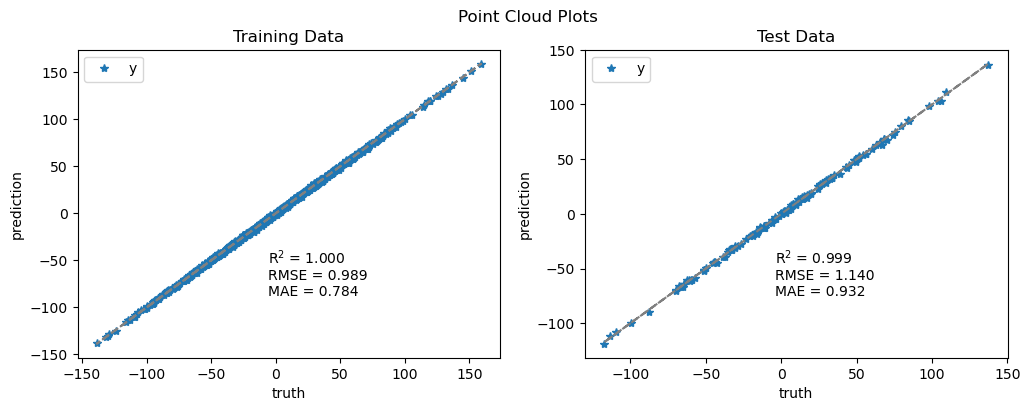

In [41]:
# Training data
r_sq_train, rmse_train, mae_train = pred_stats(pred_train, y_train_real)
r_sq_test, rmse_test, mae_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label=f"y")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", color="grey")
# ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
ax1.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_train:0.3f}\nRMSE = {rmse_train:0.3f}\nMAE = {mae_train:0.3f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")

# Test plot
ax3.plot(y_test_real, pred_test, marker="*", linestyle="None", label=f"y")
ax3.plot(y_test_real, y_test_real, linestyle="dashed", color="grey")
# ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
ax3.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_test:0.3f}\nRMSE = {rmse_test:0.3f}\nMAE = {mae_test:0.3f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()

### Changing some hyperparameters

In [42]:
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         # self.mean_module = gpytorch.means.ConstantMean()
#         self.mean_module = gpytorch.means.ZeroMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=n_feats))

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# # initialize likelihood and model
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = ExactGPModel(x_train_torch, y_train_torch, likelihood)

In [43]:
# %%time
# model.train()
# likelihood.train()

# training_iter = 300
# learning_rate = 0.1

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                # Includes GaussianLikelihood parameters
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)       # "Loss" for GPs - the marginal log likelihood
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.75 * training_iter], gamma=0.1)

# losses =  []
# with tqdm.trange(training_iter) as pbar:
#     for i in pbar:
#         optimizer.zero_grad()                                   # Zero gradients from previous iteration
#         output = model(x_train_torch)                 # Output from model
#         loss = -mll(output, y_train_torch)  # Calc loss, the marginal log likelihood
        
#         losses.append(loss.item())
#         pbar.set_postfix({'loss': loss.item(),'noise': model.likelihood.noise.item(), 'lengthscale':model.covar_module.base_kernel.lengthscale.detach().numpy()})

#         model.train()
#         likelihood.train()
        
#         loss.backward()  # backprop gradients
#         optimizer.step()
#         scheduler.step()

# g, ax = plt.subplots(figsize=(5, 3))
# ax.plot(losses)
# ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")

In [44]:
# model.eval()        # Put the model into evaluation mode
# likelihood.eval()
# # Evaluate the model performance on train and validation data
# pred_norm = model(torch.from_numpy(x_norm)).mean.detach().numpy().reshape(-1, 1)
# pred_norm_train = model(torch.from_numpy(x_train)).mean.detach().numpy().reshape(-1, 1)
# pred_norm_test = model(torch.from_numpy(x_test)).mean.detach().numpy().reshape(-1, 1)

# # Unscale the results and plot
# pred_full = scaler_y.inverse_transform(pred_norm)
# pred_train = scaler_y.inverse_transform(pred_norm_train)
# pred_test = scaler_y.inverse_transform(pred_norm_test)

In [45]:

    
# # Training data
# r_sq_train, rmse_train, rmspe_train = pred_stats(pred_train, y_train_real)
# r_sq_test, rmse_test, rmspe_test = pred_stats(pred_test, y_test_real)

# # Visualize the predictions using a cloud plot
# fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 4))
# # Train plot
# ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label=f"y")
# ax1.plot(y_train_real, y_train_real, linestyle="dashed", color="grey")
# # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
# ax1.text(x=0.45, y=0.2, s=rf"y: R$^2$ = {r_sq_train[0]:0.3f}, RMSE = {rmse_train[0]:0.3f}", transform=ax1.transAxes)
# ax1.legend()
# ax1.set_xlabel("truth")
# ax1.set_ylabel("prediction")
# ax1.set_title("Training Data")

# # Test plot
# ax3.plot(y_test_real, pred_test, marker="*", linestyle="None", label=f"y")
# ax3.plot(y_test_real, y_test_real, linestyle="dashed", color="grey")
# # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
# ax3.text(x=0.45, y=0.2, s=rf"y: R$^2$ = {r_sq_test[0]:0.3f}, RMSE = {rmse_test[0]:0.3f}", transform=ax3.transAxes)
# ax3.legend()
# ax3.set_xlabel("truth")
# ax3.set_ylabel("prediction")
# ax3.set_title("Test Data")

# fig.suptitle('Point Cloud Plots')
# plt.show()

# Scientific data from building simulation 

In [46]:
df = pd.read_csv('../../data/energyplus_building_data.csv')
df

,T_in,Q_hvac,T_out,Q_solar,Q_in,y
0,22.938482,0.0,12.683333,0.0,0.014134,22.900186
1,22.900186,0.0,12.450000,0.0,0.014134,22.857756
2,22.857756,0.0,12.216667,0.0,0.014134,22.814235
3,22.814235,0.0,11.983333,0.0,0.014134,22.770549
4,22.770549,0.0,11.750000,0.0,0.014134,22.726989
...,...,...,...,...,...,...
105113,23.784739,0.0,11.695833,0.0,0.016413,23.754518
105114,23.754518,0.0,11.604167,0.0,0.016413,23.724582
105115,23.724582,0.0,11.512500,0.0,0.016413,23.694909
105116,23.694909,0.0,11.420833,0.0,0.016413,23.665464


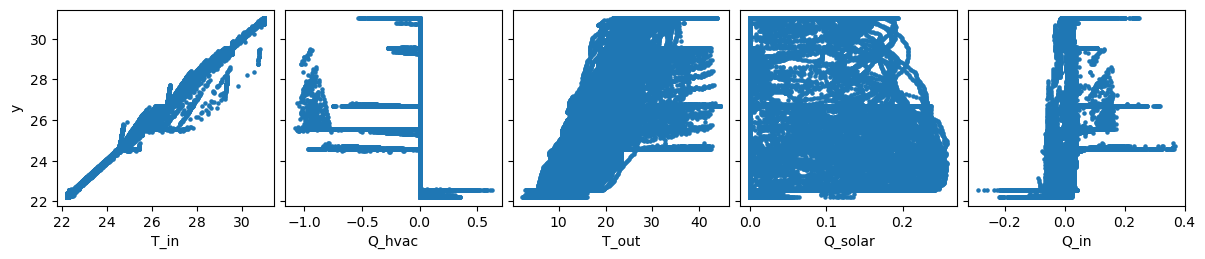

In [61]:
input_names = ["T_in", "Q_hvac", "T_out", "Q_solar", "Q_in"]
output_name = 'y'
fig, ax = plt.subplots(1, len(input_names), figsize=(12, 2.), sharey='row')
for i, input in enumerate(input_names):
    ax[i].scatter(df[input], df[output_name], s=5)
    ax[i].set_xlabel(input)
ax[0].set_ylabel(output_name)
fig.subplots_adjust(left=0.05, right=0.99, wspace=0.05, bottom=0.01, top=0.99)

In [47]:
X = df[["T_in", "Q_hvac", "T_out", "Q_solar", "Q_in"]].to_numpy()
y = df['y'].to_numpy()

scaler = preprocessing.StandardScaler().fit(X)
x_norm = scaler.transform(X)

scaler_y = preprocessing.StandardScaler().fit(y.reshape(-1, 1))
y_norm = scaler_y.transform(y.reshape(-1, 1))

print(f"X.shape:{x_norm.shape}")
print(f"y.shape:{y_norm.shape}")

X.shape:(105118, 5)
y.shape:(105118, 1)


In [48]:
# Set aside 10% of the data for future testing
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, shuffle=True, random_state=42)
y_test_real = scaler_y.inverse_transform(y_test)

n_train = 2500
test_ratio = 1-n_train/x_train.shape[0]

x_train_small, _, y_train_small, _ = train_test_split(x_train, y_train, test_size=test_ratio, shuffle=True)
x_train_torch = torch.from_numpy(x_train_small)
y_train_torch = torch.from_numpy(y_train_small.flatten())
y_train_real = scaler_y.inverse_transform(y_train_small)
print(f"train data: {x_train_small.shape}, {y_train_small.shape}")
print(f"test data: {x_test.shape}, {y_test.shape}")

train data: (2500, 5), (2500, 1)
test data: (21024, 5), (21024, 1)


In [49]:
n_data, n_params = X.shape
batch_size = 4096
n_batches = int(n_data/batch_size)
x_batch = x_norm[:n_batches*batch_size, :5].reshape(n_batches, -1, n_params)
print(x_batch.shape)
x_batch_torch = torch.from_numpy(x_batch)

(25, 4096, 5)


## GP using GPytorch

In [50]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train_torch, y_train_torch, likelihood)

100%|██████████| 300/300 [01:03<00:00,  4.76it/s, loss=-3.32, noise=0.000103, lengthscale=4.75]

CPU times: user 7min 50s, sys: 17.8 s, total: 8min 8s
Wall time: 1min 3s


[Text(0.5, 1.0, 'Loss'),
 Text(0.5, 0, 'Iterations'),
 Text(0, 0.5, 'Negative Log-Likelihood')]

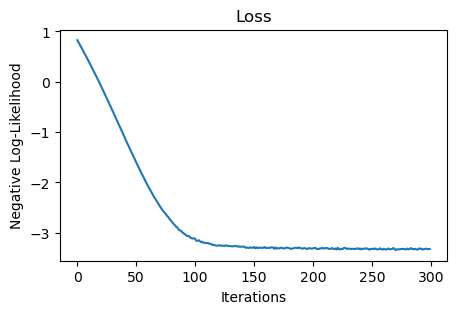

In [51]:
%%time
model.train()
likelihood.train()

training_iter = 300
learning_rate = 0.1

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)       # "Loss" for GPs - the marginal log likelihood

losses =  []
with tqdm.trange(training_iter) as pbar:
    for i in pbar:
        optimizer.zero_grad()                                   # Zero gradients from previous iteration
        output = model(x_train_torch)                 # Output from model
        loss = -mll(output, y_train_torch)  # Calc loss, the marginal log likelihood
        
        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item(),'noise': model.likelihood.noise.item(), 'lengthscale':model.covar_module.base_kernel.lengthscale.item()})

        model.train()
        likelihood.train()
        
        loss.backward()  # backprop gradients
        optimizer.step()

g, ax = plt.subplots(figsize=(5, 3))
ax.plot(losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")

In [52]:
model.eval()        # Put the model into evaluation mode
likelihood.eval()
# Evaluate the model performance on train data
pred_norm_train = model(x_train_torch).mean.detach().numpy().reshape(-1, 1)
pred_train = scaler_y.inverse_transform(pred_norm_train)


/usr/local/anaconda3/envs/nrel-ai/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [53]:
# Evaluate the model performance on test data
pred_norm_test = model(torch.from_numpy(x_test)).mean.detach().numpy().reshape(-1, 1)
pred_test = scaler_y.inverse_transform(pred_norm_test)

In [54]:
observed_pred = likelihood(model(x_batch_torch))
pred_norm = observed_pred.mean.detach().numpy().reshape(-1, 1)
var = observed_pred.variance.detach().numpy().reshape(-1, 1)

pred_full = scaler_y.inverse_transform(pred_norm).flatten()
var_real = (scaler_y.scale_*var).flatten()

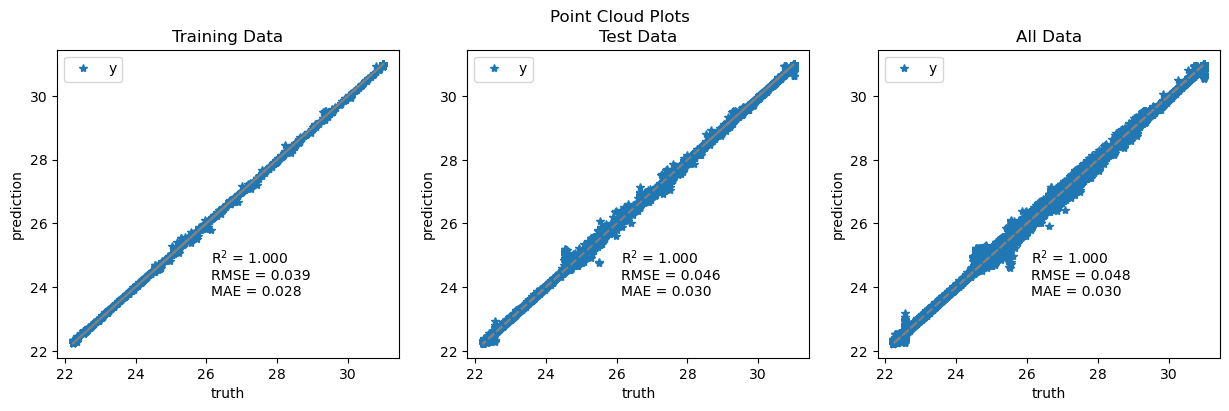

In [59]:
# Training data
r_sq_train, rmse_train, mae_train = pred_stats(pred_train, y_train_real)
r_sq_test, rmse_test, mae_test = pred_stats(pred_test, y_test_real)
r_sq_full, rmse_full, mae_full = pred_stats(pred_full, y[:n_batches*batch_size])

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label=f"y")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", color="grey")
# ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
ax1.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_train:0.3f}\nRMSE = {rmse_train:0.3f}\nMAE = {mae_train:0.3f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")

# Test plot
ax2.plot(y_test_real, pred_test, marker="*", linestyle="None", label=f"y")
ax2.plot(y_test_real, y_test_real, linestyle="dashed", color="grey")
# ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
ax2.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_test:0.3f}\nRMSE = {rmse_test:0.3f}\nMAE = {mae_test:0.3f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Test Data")

# Full plot
ax3.plot(y[:n_batches*batch_size], pred_full, marker="*", linestyle="None", label=f"y")
ax3.plot(y[:n_batches*batch_size], y[:n_batches*batch_size], linestyle="dashed", color="grey")
# ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
ax3.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_full:0.3f}\nRMSE = {rmse_full:0.3f}\nMAE = {mae_full:0.3f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("All Data")

fig.suptitle('Point Cloud Plots')
plt.show()

Text(0, 0.5, '2std')

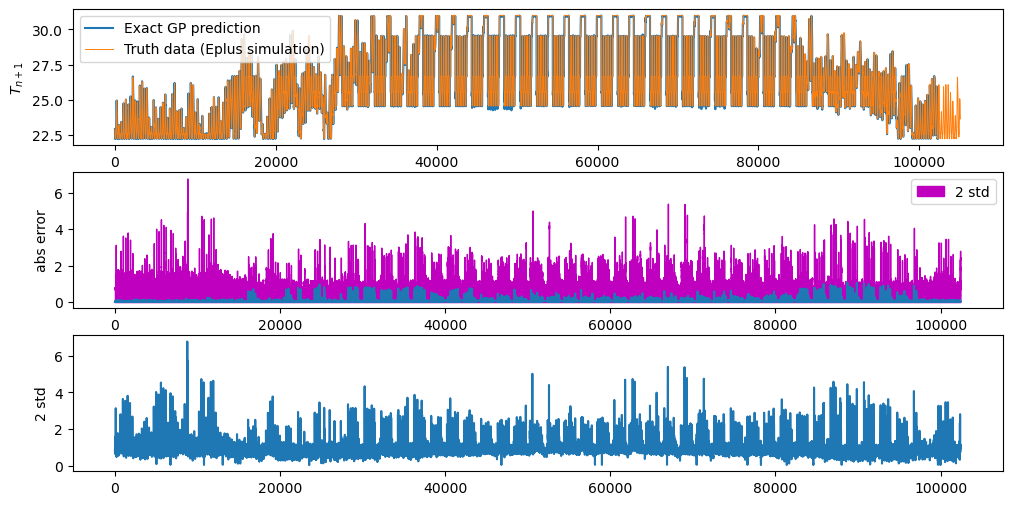

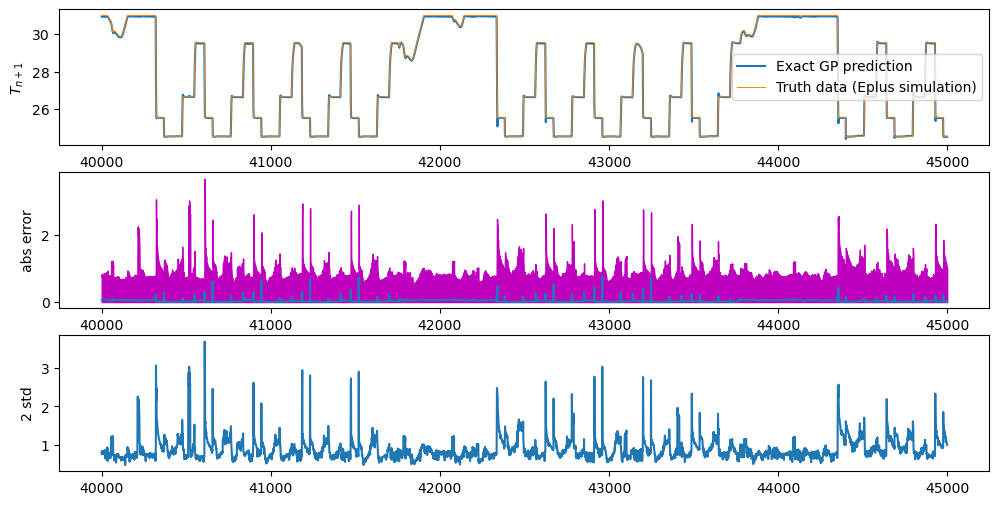

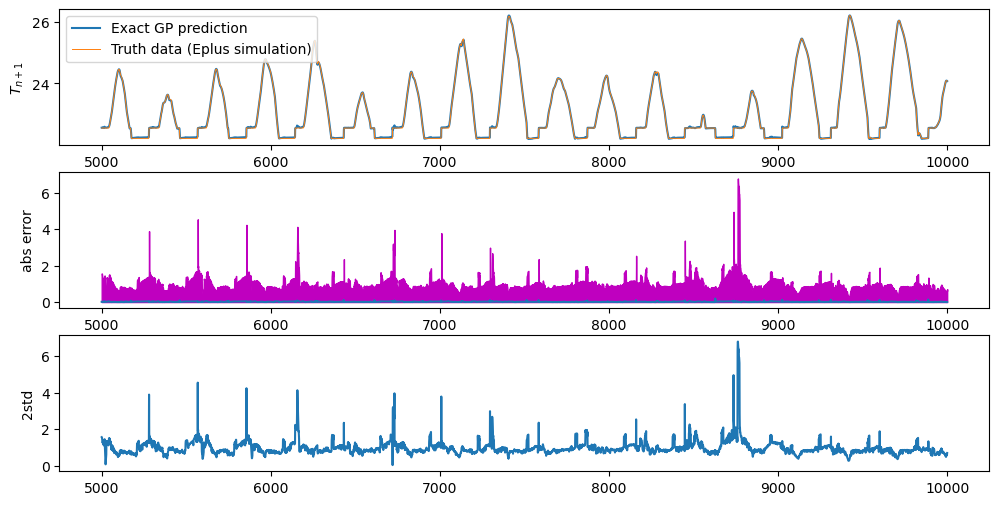

In [ ]:
error = np.abs(pred_full - y[:n_batches*batch_size])
confidence = 2*np.sqrt(var_real)

fig, ax = plt.subplots(3, 1, figsize=(12, 6))
x = np.arange(len(pred_full))
ax[0].plot(pred_full, label=f'Exact GP prediction')
ax[0].plot(y, lw=0.7, label='Truth data (Eplus simulation)')
ax[0].set_ylabel(r'$T_{n+1}$')
ax[0].legend()
ax[1].fill_between(x, [0.0]*len(x), confidence, color='m', label='2 std')
ax[1].plot(error)
ax[1].legend()
ax[1].set_ylabel('abs error')
ax[2].plot(confidence)
ax[2].set_ylabel('2 std')

x = np.arange(40000, 45000)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(x, pred_full[40000:45000], label=f'Exact GP prediction')
ax[0].plot(x, y[40000:45000], lw=0.7, label='Truth data (Eplus simulation)')
ax[0].set_ylabel(r'$T_{n+1}$')
ax[0].legend()
ax[1].fill_between(x, [0.0]*len(x), confidence[40000:45000], color='m', label='2 std')
ax[1].plot(x, error[40000:45000])

ax[1].set_ylabel('abs error')
ax[2].plot(x, confidence[40000:45000])
ax[2].set_ylabel('2 std')

x = np.arange(5000,10000)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(x, pred_full[5000:10000], label=f'Exact GP prediction')
ax[0].plot(x, y[5000:10000], lw=0.7, label='Truth data (Eplus simulation)')
ax[0].set_ylabel(r'$T_{n+1}$')
ax[0].legend()
ax[1].fill_between(x, [0.0]*len(x), confidence[5000:10000], color='m', label='2 std')
ax[1].plot(x, error[5000:10000])
ax[1].set_ylabel('abs error')
ax[2].plot(x, confidence[5000:10000])
ax[2].set_ylabel('2std')

### Tune some hyperparameters

In [62]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=X.shape[1], lengthscale_constraint=gpytorch.constraints.GreaterThan(1e-2)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(5e-4))
model = ExactGPModel(torch.from_numpy(x_train_small), torch.from_numpy(y_train_small.flatten()), likelihood)

In [63]:
%%time
model.train()
likelihood.train()

training_iter = 200
learning_rate = 0.1

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)       # "Loss" for GPs - the marginal log likelihood
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.75 * training_iter], gamma=0.1)

losses =  []
with tqdm.trange(training_iter) as pbar:
    for i in pbar:
        optimizer.zero_grad()                                   # Zero gradients from previous iteration
        output = model(torch.from_numpy(x_train_small))                 # Output from model
        loss = -mll(output, torch.from_numpy(y_train_small.flatten()))  # Calc loss, the marginal log likelihood
        
        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item(),'noise': model.likelihood.noise.item(), 'lengthscales':model.covar_module.base_kernel.lengthscale.detach().numpy()})

        model.train()
        likelihood.train()
        
        loss.backward()  # backprop gradients
        optimizer.step()
        scheduler.step()

100%|██████████| 200/200 [01:22<00:00,  2.41it/s, loss=-2.63, noise=0.000545, lengthscales=[[2.788538  4.9840064 6.3597913 9.198528  8.713996 ]]]

CPU times: user 10min 21s, sys: 33.7 s, total: 10min 55s
Wall time: 1min 22s


Parameter name: likelihood.noise_covar.raw_noise           value = [-10.003979]
Parameter name: covar_module.raw_outputscale               value = -1.067525029182434
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[2.7140348 4.967159  6.3498006 9.191844  8.706921 ]]


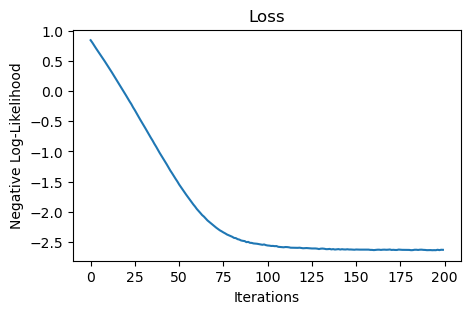

In [64]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.detach().numpy()}')

In [65]:
model.eval()        # Put the model into evaluation mode
likelihood.eval()
# Evaluate the model performance on train data
pred_norm_train = model(x_train_torch).mean.detach().numpy().reshape(-1, 1)
pred_train = scaler_y.inverse_transform(pred_norm_train)

/usr/local/anaconda3/envs/nrel-ai/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [66]:
# Evaluate the model performance on test data
pred_norm_test = model(torch.from_numpy(x_test)).mean.detach().numpy().reshape(-1, 1)
pred_test = scaler_y.inverse_transform(pred_norm_test)

In [67]:
observed_pred = likelihood(model(x_batch_torch))
pred_norm = observed_pred.mean.detach().numpy().reshape(-1, 1)
var = observed_pred.variance.detach().numpy().reshape(-1, 1)

pred_full = scaler_y.inverse_transform(pred_norm).flatten()
var_real = (scaler_y.scale_*var).flatten()

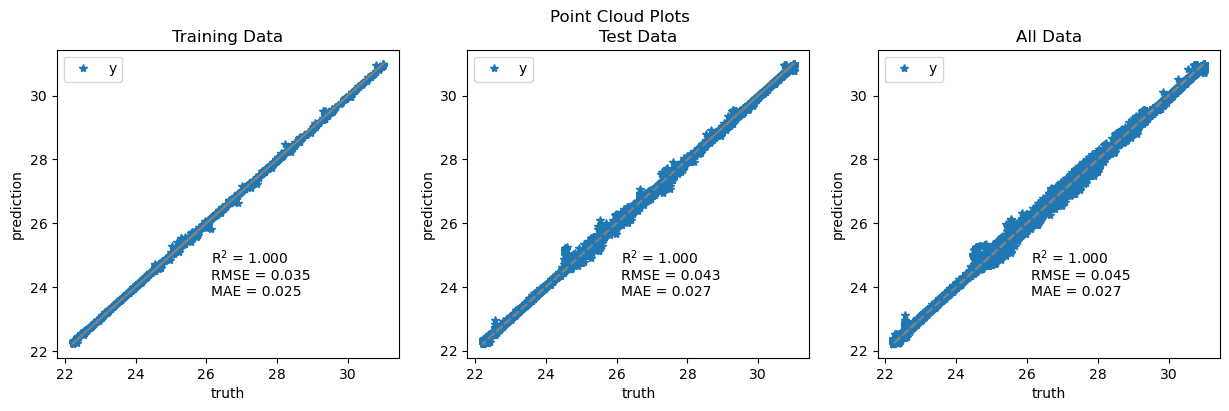

In [68]:
# Training data
r_sq_train, rmse_train, mae_train = pred_stats(pred_train, y_train_real)
r_sq_test, rmse_test, mae_test = pred_stats(pred_test, y_test_real)
r_sq_full, rmse_full, mae_full = pred_stats(pred_full, y[:n_batches*batch_size])

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label=f"y")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", color="grey")
# ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
ax1.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_train:0.3f}\nRMSE = {rmse_train:0.3f}\nMAE = {mae_train:0.3f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")

# Test plot
ax2.plot(y_test_real, pred_test, marker="*", linestyle="None", label=f"y")
ax2.plot(y_test_real, y_test_real, linestyle="dashed", color="grey")
# ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
ax2.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_test:0.3f}\nRMSE = {rmse_test:0.3f}\nMAE = {mae_test:0.3f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Test Data")

# Full plot
ax3.plot(y[:n_batches*batch_size], pred_full, marker="*", linestyle="None", label=f"y")
ax3.plot(y[:n_batches*batch_size], y[:n_batches*batch_size], linestyle="dashed", color="grey")
# ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
ax3.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_full:0.3f}\nRMSE = {rmse_full:0.3f}\nMAE = {mae_full:0.3f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("All Data")

fig.suptitle('Point Cloud Plots')
plt.show()

Text(0, 0.5, '2std')

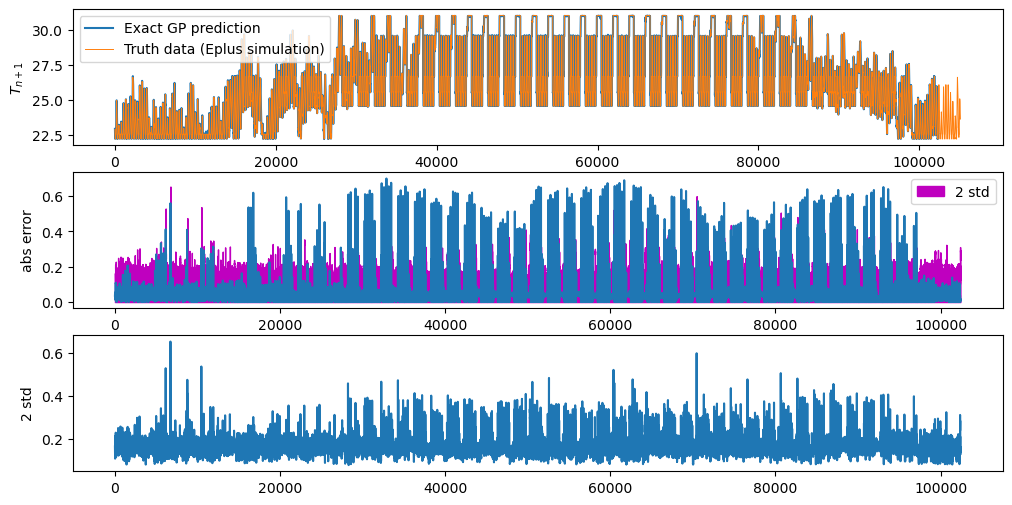

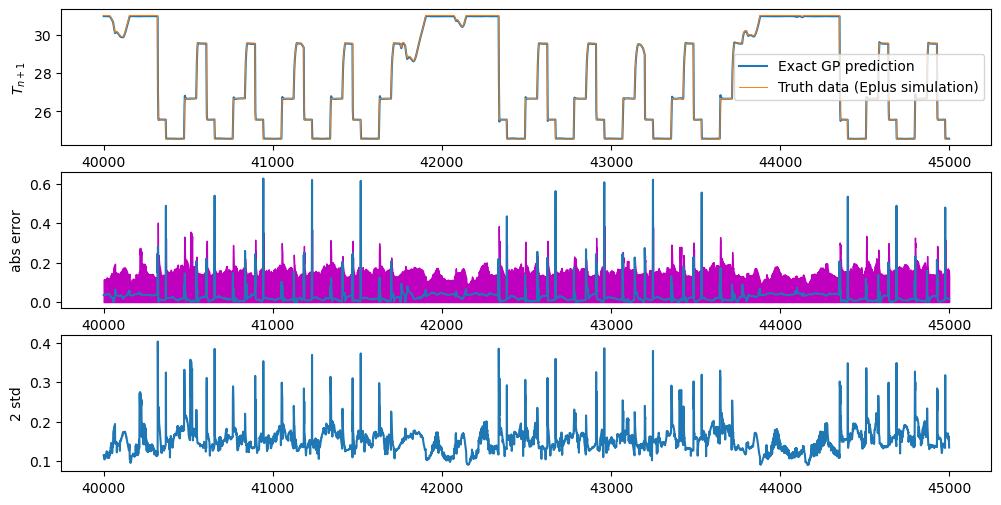

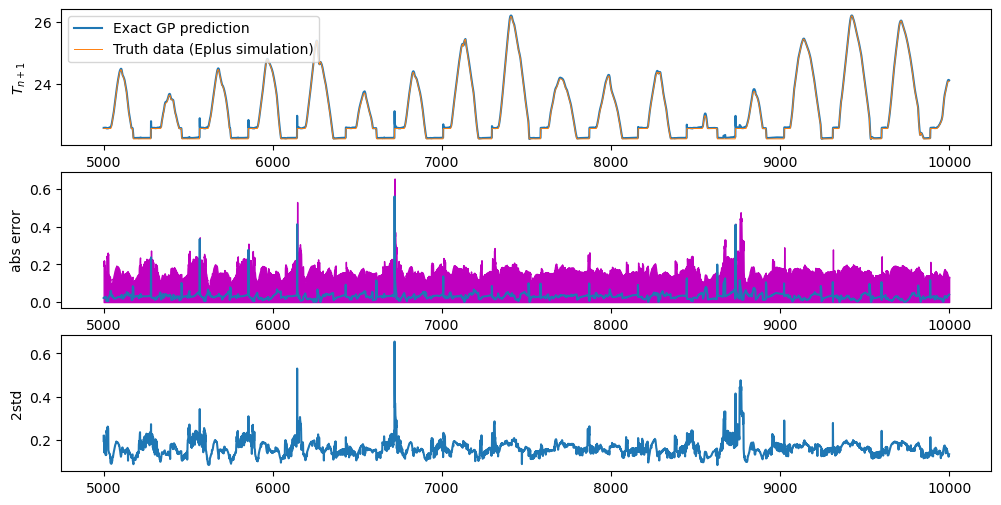

In [69]:
error = np.abs(pred_full - y[:n_batches*batch_size])
confidence = 2*np.sqrt(var_real)

fig, ax = plt.subplots(3, 1, figsize=(12, 6))
x = np.arange(len(pred_full))
ax[0].plot(pred_full, label=f'Exact GP prediction')
ax[0].plot(y, lw=0.7, label='Truth data (Eplus simulation)')
ax[0].set_ylabel(r'$T_{n+1}$')
ax[0].legend()
ax[1].fill_between(x, [0.0]*len(x), confidence, color='m', label='2 std')
ax[1].plot(error)
ax[1].legend()
ax[1].set_ylabel('abs error')
ax[2].plot(confidence)
ax[2].set_ylabel('2 std')

x = np.arange(40000, 45000)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(x, pred_full[40000:45000], label=f'Exact GP prediction')
ax[0].plot(x, y[40000:45000], lw=0.7, label='Truth data (Eplus simulation)')
ax[0].set_ylabel(r'$T_{n+1}$')
ax[0].legend()
ax[1].fill_between(x, [0.0]*len(x), confidence[40000:45000], color='m', label='2 std')
ax[1].plot(x, error[40000:45000])

ax[1].set_ylabel('abs error')
ax[2].plot(x, confidence[40000:45000])
ax[2].set_ylabel('2 std')

x = np.arange(5000,10000)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(x, pred_full[5000:10000], label=f'Exact GP prediction')
ax[0].plot(x, y[5000:10000], lw=0.7, label='Truth data (Eplus simulation)')
ax[0].set_ylabel(r'$T_{n+1}$')
ax[0].legend()
ax[1].fill_between(x, [0.0]*len(x), confidence[5000:10000], color='m', label='2 std')
ax[1].plot(x, error[5000:10000])
ax[1].set_ylabel('abs error')
ax[2].plot(x, confidence[5000:10000])
ax[2].set_ylabel('2std')

## Sparse GP using GPytorch

In [70]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        # self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module = gpytorch.means.ZeroMean()
        self.base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=X.shape[1]), lengthscale_constraint=gpytorch.constraints.GreaterThan(1e-2))
        n_points = 250
        test_ratio = 1-n_points/train_x.shape[0]
        inducing_points, _, _, _= train_test_split(x_train, y_train, test_size=test_ratio, shuffle=True)
        x_inducing = torch.from_numpy(inducing_points)
        self.covar_module = gpytorch.kernels.InducingPointKernel(self.base_covar_module, inducing_points=x_inducing, likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(5e-4))
model = GPRegressionModel(torch.from_numpy(x_train), torch.from_numpy(y_train.flatten()), likelihood)

100%|██████████| 200/200 [05:26<00:00,  1.63s/it, loss=-2.73, noise=0.000544]

CPU times: user 39min 34s, sys: 2min 13s, total: 41min 48s
Wall time: 5min 26s


[Text(0.5, 1.0, 'Loss'),
 Text(0.5, 0, 'Iterations'),
 Text(0, 0.5, 'Negative Log-Likelihood')]

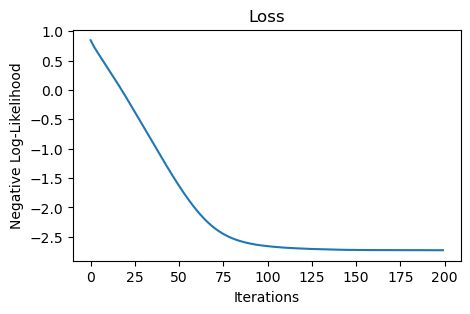

In [71]:
%%time
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

losses = []
training_iter = 200
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.75 * training_iter], gamma=0.1)
with tqdm.trange(training_iter) as pbar:
    for i in pbar:
        optimizer.zero_grad()
        output = model(torch.from_numpy(x_train))
        loss = -mll(output, torch.from_numpy(y_train.flatten()))
        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item(), 'noise': model.likelihood.noise.item()})
        loss.backward()
        optimizer.step()
        scheduler.step()
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")

In [72]:
model.eval()        # Put the model into evaluation mode
likelihood.eval()
# Evaluate the model performance on train data
pred_norm_train = model(x_train_torch).mean.detach().numpy().reshape(-1, 1)
pred_train = scaler_y.inverse_transform(pred_norm_train)

In [73]:
# Evaluate the model performance on test data
pred_norm_test = model(torch.from_numpy(x_test)).mean.detach().numpy().reshape(-1, 1)
pred_test = scaler_y.inverse_transform(pred_norm_test)

In [74]:
observed_pred = likelihood(model(x_batch_torch))
pred_norm = observed_pred.mean.detach().numpy().reshape(-1, 1)
var = observed_pred.variance.detach().numpy().reshape(-1, 1)

pred_full = scaler_y.inverse_transform(pred_norm).flatten()
var_real = (scaler_y.scale_*var).flatten()

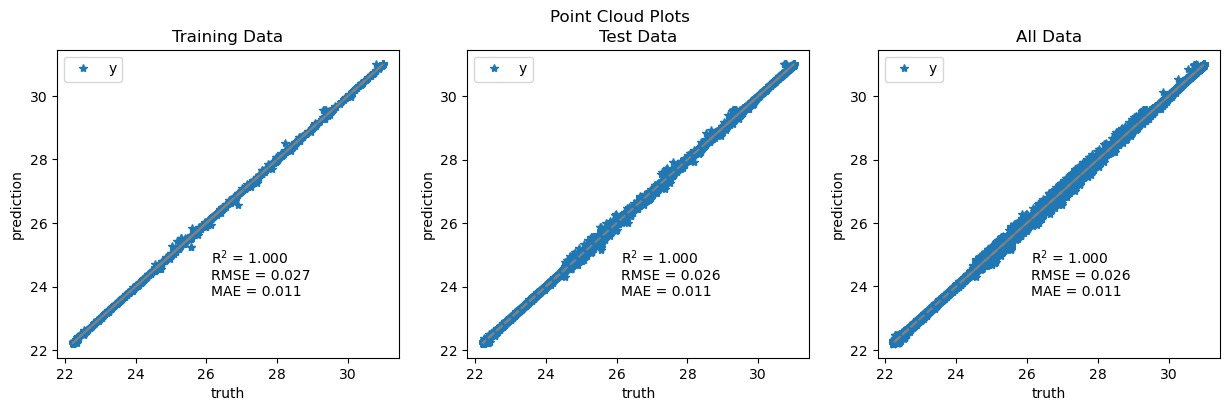

In [75]:
# Training data
r_sq_train, rmse_train, mae_train = pred_stats(pred_train, y_train_real)
r_sq_test, rmse_test, mae_test = pred_stats(pred_test, y_test_real)
r_sq_full, rmse_full, mae_full = pred_stats(pred_full, y[:n_batches*batch_size])

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label=f"y")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", color="grey")
# ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
ax1.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_train:0.3f}\nRMSE = {rmse_train:0.3f}\nMAE = {mae_train:0.3f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")

# Test plot
ax2.plot(y_test_real, pred_test, marker="*", linestyle="None", label=f"y")
ax2.plot(y_test_real, y_test_real, linestyle="dashed", color="grey")
# ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
ax2.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_test:0.3f}\nRMSE = {rmse_test:0.3f}\nMAE = {mae_test:0.3f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Test Data")

# Full plot
ax3.plot(y[:n_batches*batch_size], pred_full, marker="*", linestyle="None", label=f"y")
ax3.plot(y[:n_batches*batch_size], y[:n_batches*batch_size], linestyle="dashed", color="grey")
# ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
ax3.text(x=0.45, y=0.2, s=f"R$^2$ = {r_sq_full:0.3f}\nRMSE = {rmse_full:0.3f}\nMAE = {mae_full:0.3f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("All Data")

fig.suptitle('Point Cloud Plots')
plt.show()

Text(0, 0.5, '2std')

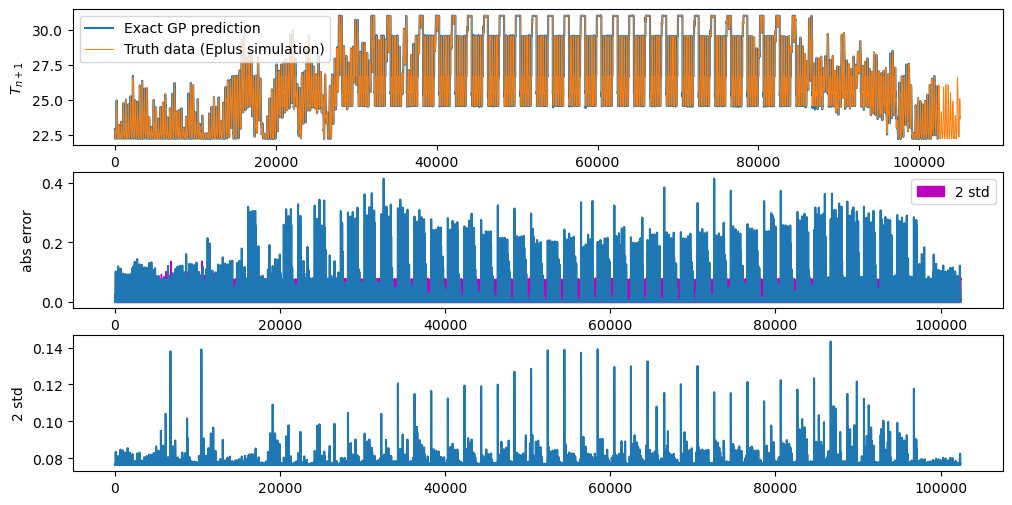

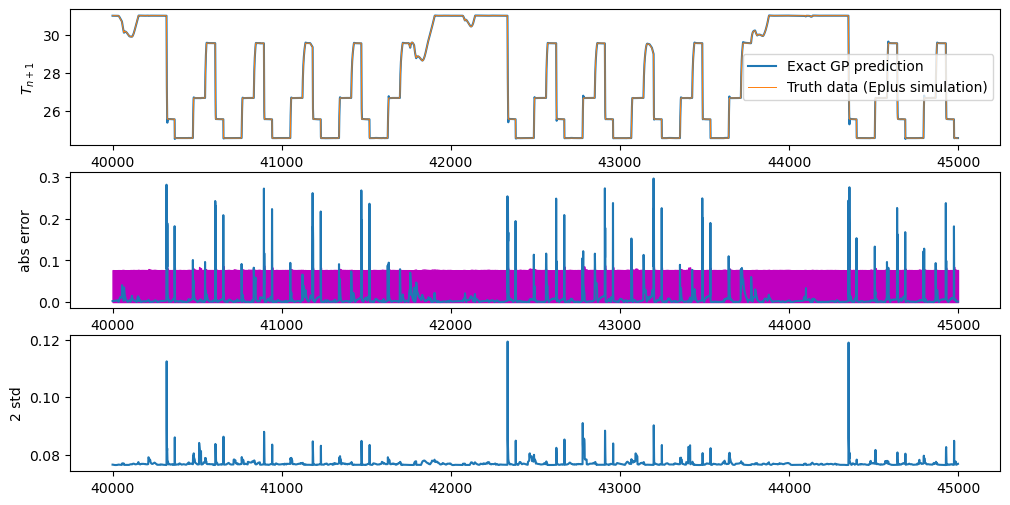

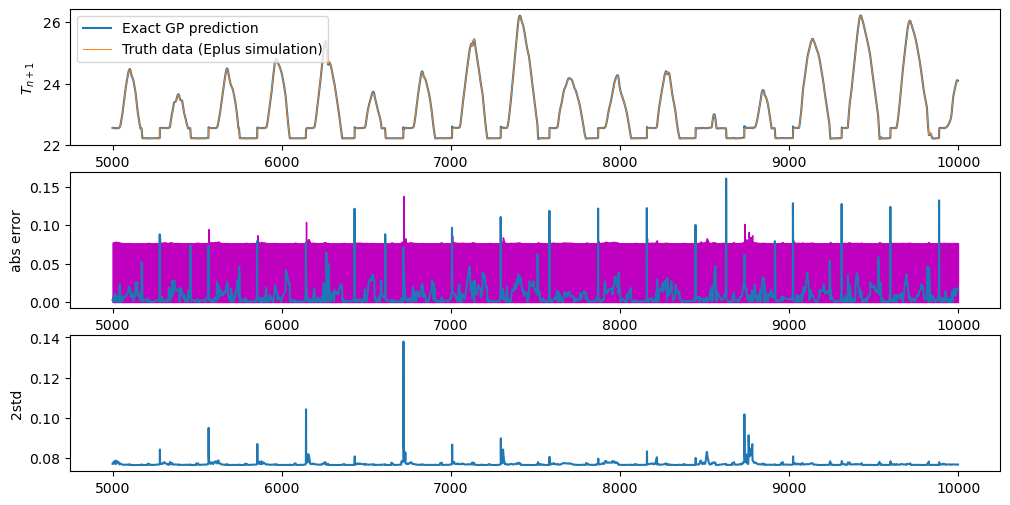

In [76]:
error = np.abs(pred_full - y[:n_batches*batch_size])
confidence = 2*np.sqrt(var_real)

fig, ax = plt.subplots(3, 1, figsize=(12, 6))
x = np.arange(len(pred_full))
ax[0].plot(pred_full, label=f'Exact GP prediction')
ax[0].plot(y, lw=0.7, label='Truth data (Eplus simulation)')
ax[0].set_ylabel(r'$T_{n+1}$')
ax[0].legend()
ax[1].fill_between(x, [0.0]*len(x), confidence, color='m', label='2 std')
ax[1].plot(error)
ax[1].legend()
ax[1].set_ylabel('abs error')
ax[2].plot(confidence)
ax[2].set_ylabel('2 std')

x = np.arange(40000, 45000)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(x, pred_full[40000:45000], label=f'Exact GP prediction')
ax[0].plot(x, y[40000:45000], lw=0.7, label='Truth data (Eplus simulation)')
ax[0].set_ylabel(r'$T_{n+1}$')
ax[0].legend()
ax[1].fill_between(x, [0.0]*len(x), confidence[40000:45000], color='m', label='2 std')
ax[1].plot(x, error[40000:45000])

ax[1].set_ylabel('abs error')
ax[2].plot(x, confidence[40000:45000])
ax[2].set_ylabel('2 std')

x = np.arange(5000,10000)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(x, pred_full[5000:10000], label=f'Exact GP prediction')
ax[0].plot(x, y[5000:10000], lw=0.7, label='Truth data (Eplus simulation)')
ax[0].set_ylabel(r'$T_{n+1}$')
ax[0].legend()
ax[1].fill_between(x, [0.0]*len(x), confidence[5000:10000], color='m', label='2 std')
ax[1].plot(x, error[5000:10000])
ax[1].set_ylabel('abs error')
ax[2].plot(x, confidence[5000:10000])
ax[2].set_ylabel('2std')